In [1]:
from sklearn.datasets import make_classification 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate

import tqdm

from imblearn.under_sampling import RandomUnderSampler 
from imblearn.under_sampling import CondensedNearestNeighbour 
from imblearn.under_sampling import TomekLinks 
from imblearn.under_sampling import OneSidedSelection 
from imblearn.under_sampling import EditedNearestNeighbours 
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
# from imblearn.under_sampling import AlIKNN 
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import InstanceHardnessThreshold


from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE 
from imblearn.over_sampling import KMeansSMOTE 
from imblearn.over_sampling import ADASYN


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # Включаем поддержку HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder


/opt/anaconda3/lib/python3.12/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
train_folder = 'train'
test_folder = 'test'


train_files = [os.path.join(train_folder, file) for file in os.listdir(train_folder) if file.endswith('.csv')]
train = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)

test_files = [os.path.join(test_folder, file) for file in os.listdir(test_folder) if file.endswith('.csv')]
test = pd.concat([pd.read_csv(file) for file in test_files], ignore_index=True)

In [4]:
df=train.copy()

In [6]:
df=df.drop(['smpl','id'],axis=1)

In [7]:
for i in df.columns:
    if df[i].dtypes=='object':
        print(i)

In [8]:
for i in df.columns:
    if df[i].isnull().sum() > 1:
        print(i,df[i].isnull().sum())

### Нет пропусков, все признаки числовые.

In [9]:
X = train.drop(['target', 'smpl'], axis=1)
y = train['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.3)


gbdt_clf = HistGradientBoostingClassifier(min_samples_leaf=1,
                                          max_depth=20,
                                          max_iter=125,
                                          random_state=42).fit(X_train, y_train)


y_pred = gbdt_clf.predict_proba(X_test)


y_pred = pd.Series(y_pred[:, 1])

print(f'Метрика roc-auc на валидационных данных имеет значение: {roc_auc_score(y_test, y_pred)}')

Метрика roc-auc на валидационных данных имеет значение: 0.7308579269231961


In [10]:
X = train.drop(['target', 'smpl'], axis=1)
y = train['target']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gbdt_clf = HistGradientBoostingClassifier(min_samples_leaf=1,
                                          max_depth=20,
                                          max_iter=125,
                                          random_state=42)

y_pred_proba = cross_val_predict(gbdt_clf, X, y, cv=cv, method='predict_proba')[:, 1]

roc_auc = roc_auc_score(y, y_pred_proba)
print("ROC AUC на тренировочных данных с кросс-валидацией:", roc_auc)

ROC AUC на тренировочных данных с кросс-валидацией: 0.736535704409926


In [11]:
X = train.drop(['target', 'smpl'], axis=1)
y = train['target']

standart=MinMaxScaler()
X_new=standart.fit_transform(X)
X=pd.DataFrame(X_new,columns=X.columns)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gbdt_clf = HistGradientBoostingClassifier(min_samples_leaf=1,
                                          max_depth=20,
                                          max_iter=125,
                                          random_state=42)

y_pred_proba = cross_val_predict(gbdt_clf, X, y, cv=cv, method='predict_proba')[:, 1]

roc_auc = roc_auc_score(y, y_pred_proba)
print("ROC AUC на тренировочных данных с кросс-валидацией и стандарт скелер:", roc_auc)

ROC AUC на тренировочных данных с кросс-валидацией и стандарт скелер: 0.736535704409926


In [12]:
def target(i,j,target='target'):
    cor_1=df.loc[:,[i,target]].corr().iloc[0,1]
    cor_2=df.loc[:,[j,target]].corr().iloc[0,1]
    if cor_1 >=cor_2:
        return j
    else:
        return i

In [13]:
lgn=len(df.columns)
bad_col=list()
for i in range(lgn):
    if i!=0:
        for j in range(i+1,lgn,1):
          col_i=df.columns[i]
          col_j=df.columns[j]
          cor=df.loc[:,[col_i,col_j]].corr().iloc[0,1]
          if abs(cor)>0.8:
                 bad_col.append(target(col_i,col_j,target='target'))        

In [15]:
for i in set(bad_col):
    del df[i]

### Было 421 признак стало 387, тк между ними высокая корреляция.

In [17]:
lgn=len(df.columns)
best_col=list()
for i in range(lgn):
    if i!=0:
         col_i=df.columns[i]
         cor=df.loc[:,[col_i,'target']].corr().iloc[0,1]
         if cor>0.1:
             best_col.append((col_i,cor))

### Нет высоко корр признаков с таргетом, максимум корр 0.05

In [20]:
similiar_col=list()
for i in df.columns:
    if i !='target':
        if df[i].min()==0.0 and df[i].max()==1.0:
                   similiar_col.append(i)

In [21]:
similiar_col_2=list()
for i in df.columns:
    if i !='target':
        if len(df[i].unique())<22:
                similiar_col_2.append(i)

In [22]:
similiar_col_3=list()
for i in df.columns:
      if i!='target':
          if df[i].min()==-5.1993375 and df[i].max()==5.1993375:
             similiar_col_3.append(i)

In [23]:
df[df['feature_3']==1]['target'].value_counts()

target
0    8889
1     409
Name: count, dtype: int64

In [28]:
data_filtered=df.copy()
for i in similiar_col_3:
    data_filtered=data_filtered.loc[(data_filtered[i]<3)]

In [34]:
df[['feature_1']].describe()

,feature_1
count,38731.000000
mean,-0.011868
std,0.992397
min,-5.199338
25%,-0.681368
50%,-0.014384
75%,0.658456
max,5.199338


***В similiar_col_3 находятся те фичи, которые неравнемерно распр, у них 75% данных меньше чем 0.7, а максимум боле 5, поэтому убираем наблюдения, которые меньше 3***

In [ ]:
data_filtered.shape

In [35]:
data_filtered['target'].value_counts()

target
0    29456
1      682
Name: count, dtype: int64

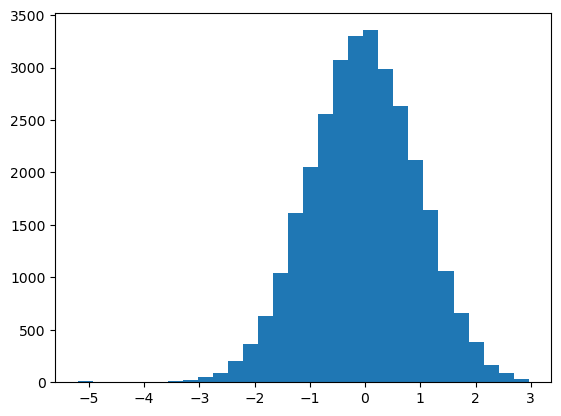

In [36]:
plt.hist(data_filtered['feature_1'],bins=30)
plt.show()

In [37]:
X = data_filtered.drop(['target'], axis=1)
y = data_filtered['target']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gbdt_clf = HistGradientBoostingClassifier(min_samples_leaf=1,
                                          max_depth=20,
                                          max_iter=125,
                                          random_state=42)

y_pred_proba = cross_val_predict(gbdt_clf, X, y, cv=cv, method='predict_proba')[:, 1]

roc_auc = roc_auc_score(y, y_pred_proba)
print("ROC AUC на тренировочных данных с кросс-валидацией:", roc_auc)

ROC AUC на тренировочных данных с кросс-валидацией: 0.7350762298078469


In [38]:
encoder = OneHotEncoder(sparse_output=False) 
encoded = encoder.fit_transform(data_filtered[similiar_col_2])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(similiar_col_2))

data_filtered = data_filtered.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

data_filtered_encoded = pd.concat([data_filtered.drop(similiar_col_2, axis=1), encoded_df], axis=1)

In [39]:
data_filtered_encoded.shape,data_filtered.shape

((30138, 457), (30138, 387))

In [40]:
X = data_filtered_encoded.drop(['target'], axis=1)
y = data_filtered_encoded['target']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gbdt_clf = HistGradientBoostingClassifier(min_samples_leaf=1,
                                          max_depth=20,
                                          max_iter=125,
                                          random_state=42)

y_pred_proba = cross_val_predict(gbdt_clf, X, y, cv=cv, method='predict_proba')[:, 1]

roc_auc = roc_auc_score(y, y_pred_proba)
print("ROC AUC на тренировочных данных с кросс-валидацией:", roc_auc)

ROC AUC на тренировочных данных с кросс-валидацией: 0.7355067641024498


In [41]:
from sklearn.ensemble import IsolationForest

X = data_filtered.drop(columns=['target']).values
model = IsolationForest(contamination=0.05)
model.fit(X)

y_pred = model.predict(X)
data_filtered['anomal']=y_pred

In [42]:
data_filtered['anomal'].value_counts()

anomal
 1    28631
-1     1507
Name: count, dtype: int64

In [43]:
X = data_filtered.drop(['target'], axis=1)
y = data_filtered['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.3)


gbdt_clf = HistGradientBoostingClassifier(min_samples_leaf=1,
                                          max_depth=20,
                                          max_iter=125,
                                          random_state=42).fit(X_train, y_train)


y_pred = gbdt_clf.predict_proba(X_test)


y_pred = pd.Series(y_pred[:, 1])

print(f'Метрика roc-auc на валидационных данных имеет значение: {roc_auc_score(y_test, y_pred)}')

Метрика roc-auc на валидационных данных имеет значение: 0.7583880966115307


In [44]:
X = data_filtered.drop(['target'], axis=1)
y = data_filtered['target']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gbdt_clf = HistGradientBoostingClassifier(min_samples_leaf=1,
                                          max_depth=20,
                                          max_iter=125,
                                          random_state=42)

y_pred_proba = cross_val_predict(gbdt_clf, X, y, cv=cv, method='predict_proba')[:, 1]

roc_auc = roc_auc_score(y, y_pred_proba)
print("ROC AUC на тренировочных данных с кросс-валидацией:", roc_auc)

ROC AUC на тренировочных данных с кросс-валидацией: 0.7350762298078469


***Train & df отработали хуже после IsolationForest, чем data_filtered***

In [47]:
orig_data_X=df.drop('target',axis=1)
orig_data_y=df[['target']]

In [48]:
orig_data_X.shape,orig_data_y.shape

((38731, 386), (38731, 1))

In [49]:
randomUnderSampler = RandomUnderSampler(sampling_strategy='auto', random_state=1, replacement=True)  
randomUnderSampler_X, randomUnderSampler_y = randomUnderSampler.fit_resample(orig_data_X, orig_data_y)

In [50]:
сondensedNearestNeighbour = CondensedNearestNeighbour(sampling_strategy='auto', random_state=1, n_neighbors=1, n_jobs=-1)  
сondensedNearestNeighbour_X, сondensedNearestNeighbour_y = сondensedNearestNeighbour.fit_resample(orig_data_X, orig_data_y)


In [51]:
tomekLinks = TomekLinks(sampling_strategy='auto', n_jobs=-1)  
tomekLinks_X, tomekLinks_y = tomekLinks.fit_resample(orig_data_X, orig_data_y)

In [52]:
oneSidedSelection = OneSidedSelection(sampling_strategy='auto', n_neighbors=1, random_state=1)
oneSidedSelection_X, oneSidedSelection_y =oneSidedSelection.fit_resample(orig_data_X,orig_data_y)

In [53]:
editedNearestNeighbours1 = EditedNearestNeighbours(sampling_strategy='auto', kind_sel= 'all')
editedNearestNeighbours1_X, editedNearestNeighbours1_y = editedNearestNeighbours1.fit_resample(orig_data_X, orig_data_y)

In [54]:
editedNearestNeighbours2 = EditedNearestNeighbours(sampling_strategy='auto', kind_sel= 'mode')
editedNearestNeighbours2_X, editedNearestNeighbours2_y = editedNearestNeighbours2.fit_resample(orig_data_X, orig_data_y)

In [55]:
editedRepeatedNearestNeighbours1 = RepeatedEditedNearestNeighbours(sampling_strategy='auto',kind_sel='all')
editedRepeatedNearestNeighbours1_X, editedRepeatedNearestNeighbours1_y = editedRepeatedNearestNeighbours1.fit_resample(orig_data_X,orig_data_y)

In [56]:
editedRepeatedNearestNeighbours2 = RepeatedEditedNearestNeighbours(sampling_strategy='auto',kind_sel='mode')
editedRepeatedNearestNeighbours2_X, editedRepeatedNearestNeighbours2_y = editedRepeatedNearestNeighbours2.fit_resample(orig_data_X,orig_data_y)

In [57]:
neighbourhoodCleaningRule = NeighbourhoodCleaningRule(sampling_strategy='auto', n_jobs=-1)
neighbourhoodCleaningRule_X, neighbourhoodCleaningRule_y = neighbourhoodCleaningRule.fit_resample(orig_data_X, orig_data_y)

In [58]:
iht = InstanceHardnessThreshold(
             estimator=RandomForestClassifier(n_estimators=100, random_state=1), 
             sampling_strategy='auto', 
             random_state=1, n_jobs=-1, cv=3)
iht_X, iht_y = iht.fit_resample(orig_data_X, orig_data_y)

In [76]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric'] == metric) & (self.df['alg'] == alg)].index, inplace=True)
        
        # Добавление нового значения
        temp = [{'metric': metric, 'alg': alg, 'value': value}]
        self.df = pd.concat([self.df, pd.DataFrame(temp)], ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.05, a-0.05, str(round(b,3)), color='white')
        plt.show()

In [77]:
us_clas_models_dict = {'LogR': LogisticRegression(max_iter=1000, random_state=1) ,
'SVC': SVC(probability=True),
'KNN 5': KNeighborsClassifier(n_neighbors=5),
'Tree': DecisionTreeClassifier(random_state=1),
'GB': GradientBoostingClassifier(random_state=1),
'RF': RandomForestClassifier(n_estimators=200, random_state=1)}



In [83]:
us_data_list = [
    ("randomUnderSampler", randomUnderSampler_X, randomUnderSampler_y.values.ravel()),
    ("condensedNearestNeighbour", сondensedNearestNeighbour_X, сondensedNearestNeighbour_y.values.ravel()),
    ("tomekLinks", tomekLinks_X, tomekLinks_y.values.ravel()),
    ("oneSidedSelection", oneSidedSelection_X, oneSidedSelection_y.values.ravel()),
    ("editedNearestNeighbours1", editedNearestNeighbours1_X, editedNearestNeighbours1_y.values.ravel()),
    ("editedNearestNeighbours2", editedNearestNeighbours2_X, editedNearestNeighbours2_y.values.ravel()),
    ("editedRepeatedNearestNeighbours1", editedRepeatedNearestNeighbours1_X, editedRepeatedNearestNeighbours1_y.values.ravel()),
    ("editedRepeatedNearestNeighbours2", editedRepeatedNearestNeighbours2_X, editedRepeatedNearestNeighbours2_y.values.ravel()),
    ("neighbourhoodCleaningRule", neighbourhoodCleaningRule_X, neighbourhoodCleaningRule_y.values.ravel()),
]

In [70]:
# us_data_list=[
# ('Original', orig_data_X, orig_data_y),
# ('RandomUnderSampler', randomUnderSampler_X,randomUnderSampler_y),
# ('CondensedNearestNeighbour', сondensedNearestNeighbour_X, сondensedNearestNeighbour_y),
# ('TomekLinks', tomekLinks_X, tomekLinks_y),
# ('OneSidedSelection', oneSidedSelection_X, oneSidedSelection_y),
# ('EditedNearestNeighbours - kind_sel=all', editedRepeatedNearestNeighbours1_X,editedNearestNeighbours1_y),
# ('EditedNearestNeighbours - kind_sel=mode', editedNearestNeighbours2_X,editedNearestNeighbours2_y),
# ('RepeatedEditedNearestNeighbours - kind_sel=all',editedRepeatedNearestNeighbours1_X,editedRepeatedNearestNeighbours1_y),
# ('RepeatedEditedNearestNeighbours - kind_sel=mode',editedRepeatedNearestNeighbours2_X,editedRepeatedNearestNeighbours2_y),
# ('NeighbourhoodCleaningRule', neighbourhoodCleaningRule_X, neighbourhoodCleaningRule_y),
# ('InstanceHardnessThreshold', iht_X, iht_y)  
# ]

In [65]:
# def test_models(data_list, models_dict):
#     results = []
#     for model_name, model in tqdm.tqdm(models_dict.items()):
#         for data_name, X_data, y_data in data_list:
#             scores = cross_val_score(
#                 model, X_data, y_data.values.ravel(), 
#                 cv=5, scoring='roc_auc'
#             )
#             results.append({
#                 'Model': model_name,
#                 'Data': data_name,
#                 'ROC AUC (mean)': np.mean(scores),
#                 'ROC AUC (std)': np.std(scores)
#             })
#     return pd.DataFrame(results)

In [ ]:
# results_df = test_models(us_data_list, us_clas_models_dict)
# print(results_df)

In [74]:
datasets = [
    ("randomUnderSampler", randomUnderSampler_X, randomUnderSampler_y),
    ("condensedNearestNeighbour", сondensedNearestNeighbour_X, сondensedNearestNeighbour_y),
    ("tomekLinks", tomekLinks_X, tomekLinks_y),
    ("oneSidedSelection", oneSidedSelection_X, oneSidedSelection_y),
    ("editedNearestNeighbours1", editedNearestNeighbours1_X, editedNearestNeighbours1_y),
    ("editedNearestNeighbours2", editedNearestNeighbours2_X, editedNearestNeighbours2_y),
    ("editedRepeatedNearestNeighbours1", editedRepeatedNearestNeighbours1_X, editedRepeatedNearestNeighbours1_y),
    ("editedRepeatedNearestNeighbours2", editedRepeatedNearestNeighbours2_X, editedRepeatedNearestNeighbours2_y),
    ("neighbourhoodCleaningRule", neighbourhoodCleaningRule_X, neighbourhoodCleaningRule_y),
]

for name, X, y in datasets:
    print(f"{name}: X = {X.shape}, y = {y.shape}")

randomUnderSampler: X = (1686, 386), y = (1686, 1)
condensedNearestNeighbour: X = (6666, 386), y = (6666, 1)
tomekLinks: X = (38661, 386), y = (38661, 1)
oneSidedSelection: X = (38657, 386), y = (38657, 1)
editedNearestNeighbours1: X = (36419, 386), y = (36419, 1)
editedNearestNeighbours2: X = (38646, 386), y = (38646, 1)
editedRepeatedNearestNeighbours1: X = (36052, 386), y = (36052, 1)
editedRepeatedNearestNeighbours2: X = (38645, 386), y = (38645, 1)
neighbourhoodCleaningRule: X = (37025, 386), y = (37025, 1)


In [84]:
def us_test_models():
    logger = MetricLogger()
    for model_name, model in tqdm.tqdm(us_clas_models_dict.items ()) :
        for data_name, X_data, y_data in us_data_list:
            scores = cross_val_score(model, X_data, y_data,
                                      cv=3, scoring= 'roc_auc_ovr_weighted')
            logger.add(data_name, model_name, np.mean (scores) )
    return logger

In [85]:
us_logger = us_test_models ()

100%|██████████| 6/6 [26:46:35<00:00, 16065.96s/it]   


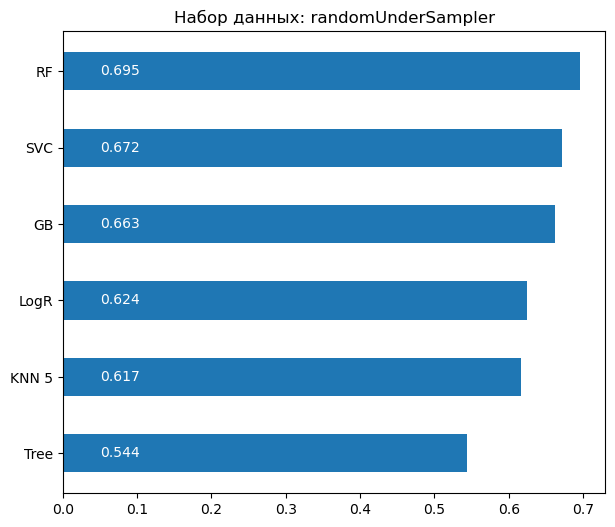

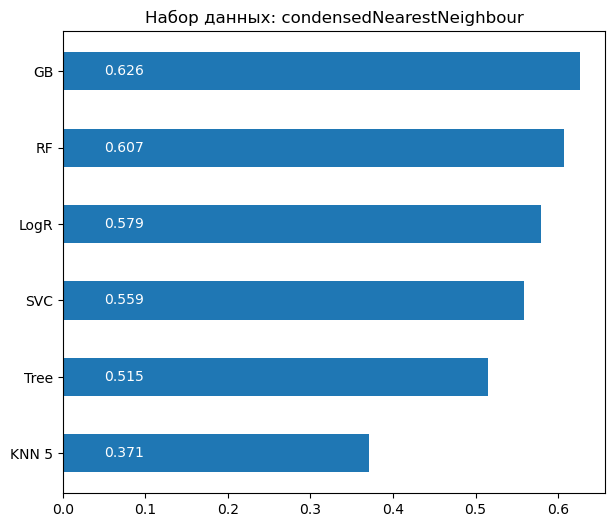

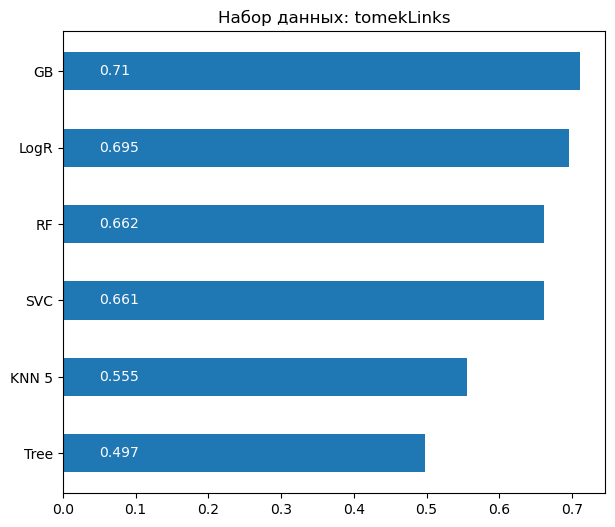

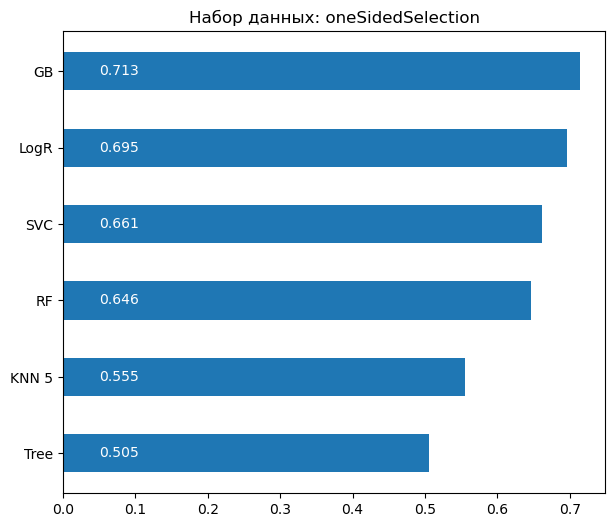

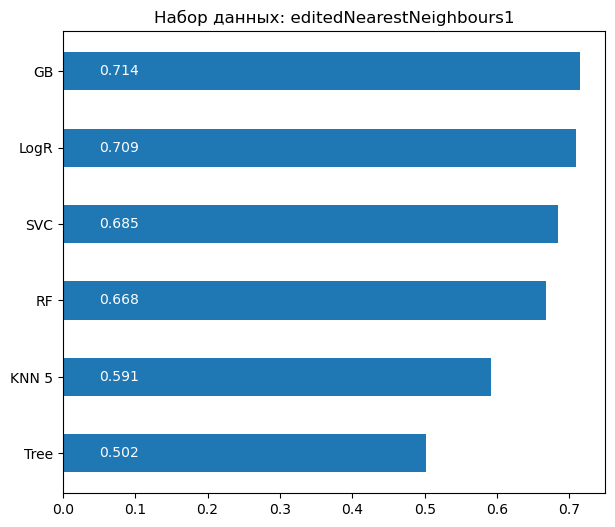

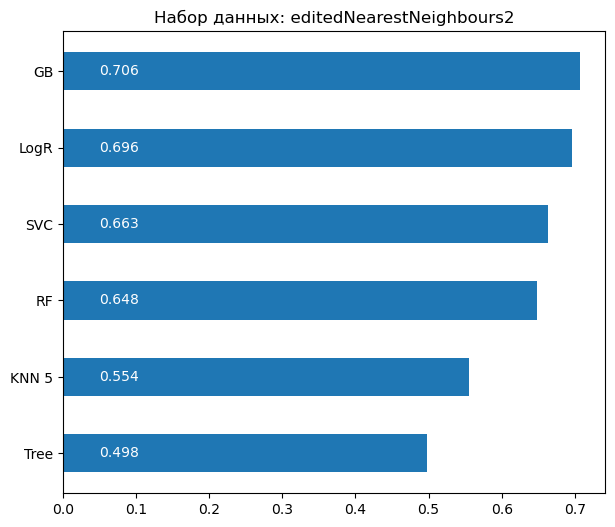

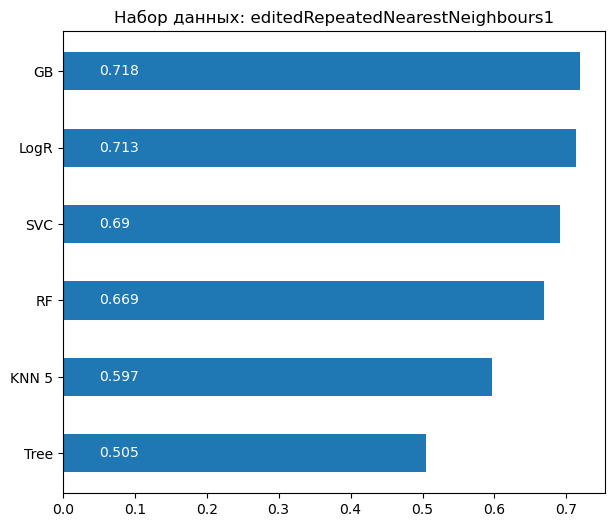

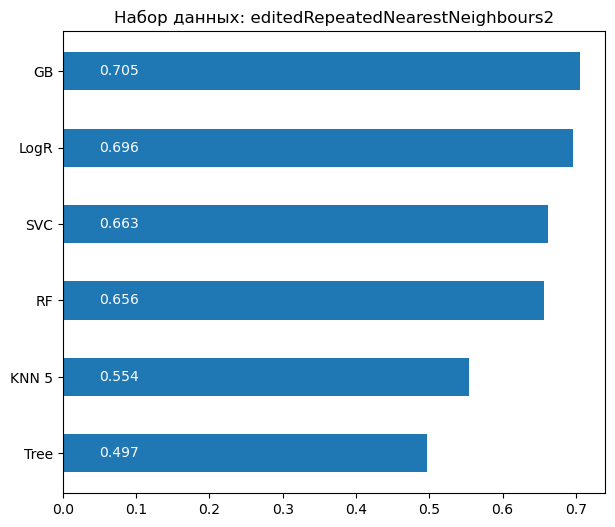

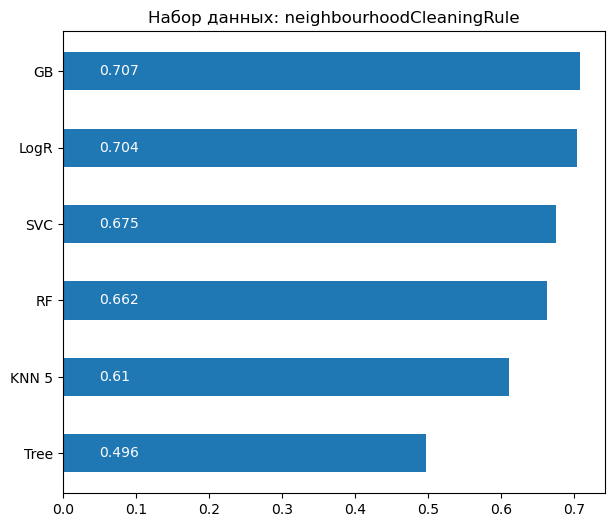

In [86]:
for data_name, _, _ in us_data_list:
    us_logger.plot('Набор данных: ' + data_name, data_name, figsize=(7, 6))